In [35]:
from flood_model_paper import *

In [30]:
from climada_petals.hazard.rf_glofas import RiverFloodInundation, save_file

time = "2007-08-02"
output_dir = DATA_GEN_DIR / "algorithm-viz"
output_dir.mkdir(exist_ok=True)

rf = RiverFloodInundation()

discharge = rf.download_reanalysis(
    countries=["India", "Bangladesh"],
    year=2007,
    preprocess=lambda x: x.sel(time=time),
    area=[26, 86, 23, 91],
)
save_file(discharge, output_dir / "glofas-historical-2007.nc")

return_period = rf.return_period()
save_file(return_period, output_dir / "return_period.nc")

return_period_interpolated = rf.regrid()
save_file(return_period_interpolated, output_dir / "return_period_interpolated.nc")

flood_depth = rf.flood_depth()
save_file(flood_depth, output_dir / "flood_depth.nc")

rf.apply_protection()
flood_depth = rf.flood_depth()
save_file(flood_depth, output_dir / "flood_depth_flopros.nc")

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 1377. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 3480. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon 

In [37]:
data = [
    "return_period.nc",
    "return_period_interpolated.nc",
    "flood_depth.nc",
    "flood_depth_flopros.nc",
]
data = [xr.open_dataarray(output_dir / file) for file in data]
dates = data[0]["time"]

In [38]:
da_discharge = xr.open_dataarray(
    output_dir / "glofas-historical-2007.nc"
)
da_discharge

<xarray.DataArray 'dis24' (time: 1, latitude: 32, longitude: 52)>
[1664 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 2007-08-02
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 26.05 25.95 25.85 25.75 ... 23.15 23.05 22.95
  * longitude   (longitude) float64 85.95 86.05 86.15 ... 90.85 90.95 91.05
    valid_time  datetime64[ns] ...
Attributes: (12/29)
    GRIB_paramId:                             240024
    GRIB_dataType:                            sfo
    GRIB_numberOfPoints:                      1664
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    ...                                       ...
    GRIB_name:                                Mean discharge in the last 24 h...
    GRIB_shortName:                           dis24
    GRIB_units:                               m**3 s**-1
    long_name:                                Mean discharge in the last 24 h...
    units:                                    m**3 s**-1
    standard_name:                            unknown

In [39]:
# Define incandescent colormap
from matplotlib.colors import LinearSegmentedColormap

clrs = [
    "#CEFFFF",
    "#C6F7D6",
    "#A2F49B",
    "#BBE453",
    "#D5CE04",
    "#E7B503",
    "#F19903",
    "#F6790B",
    "#F94902",
    "#E40515",
    "#A80003",
]
incandescent = LinearSegmentedColormap.from_list("incandescent", clrs)
# incandescent.set_bad('#888888')

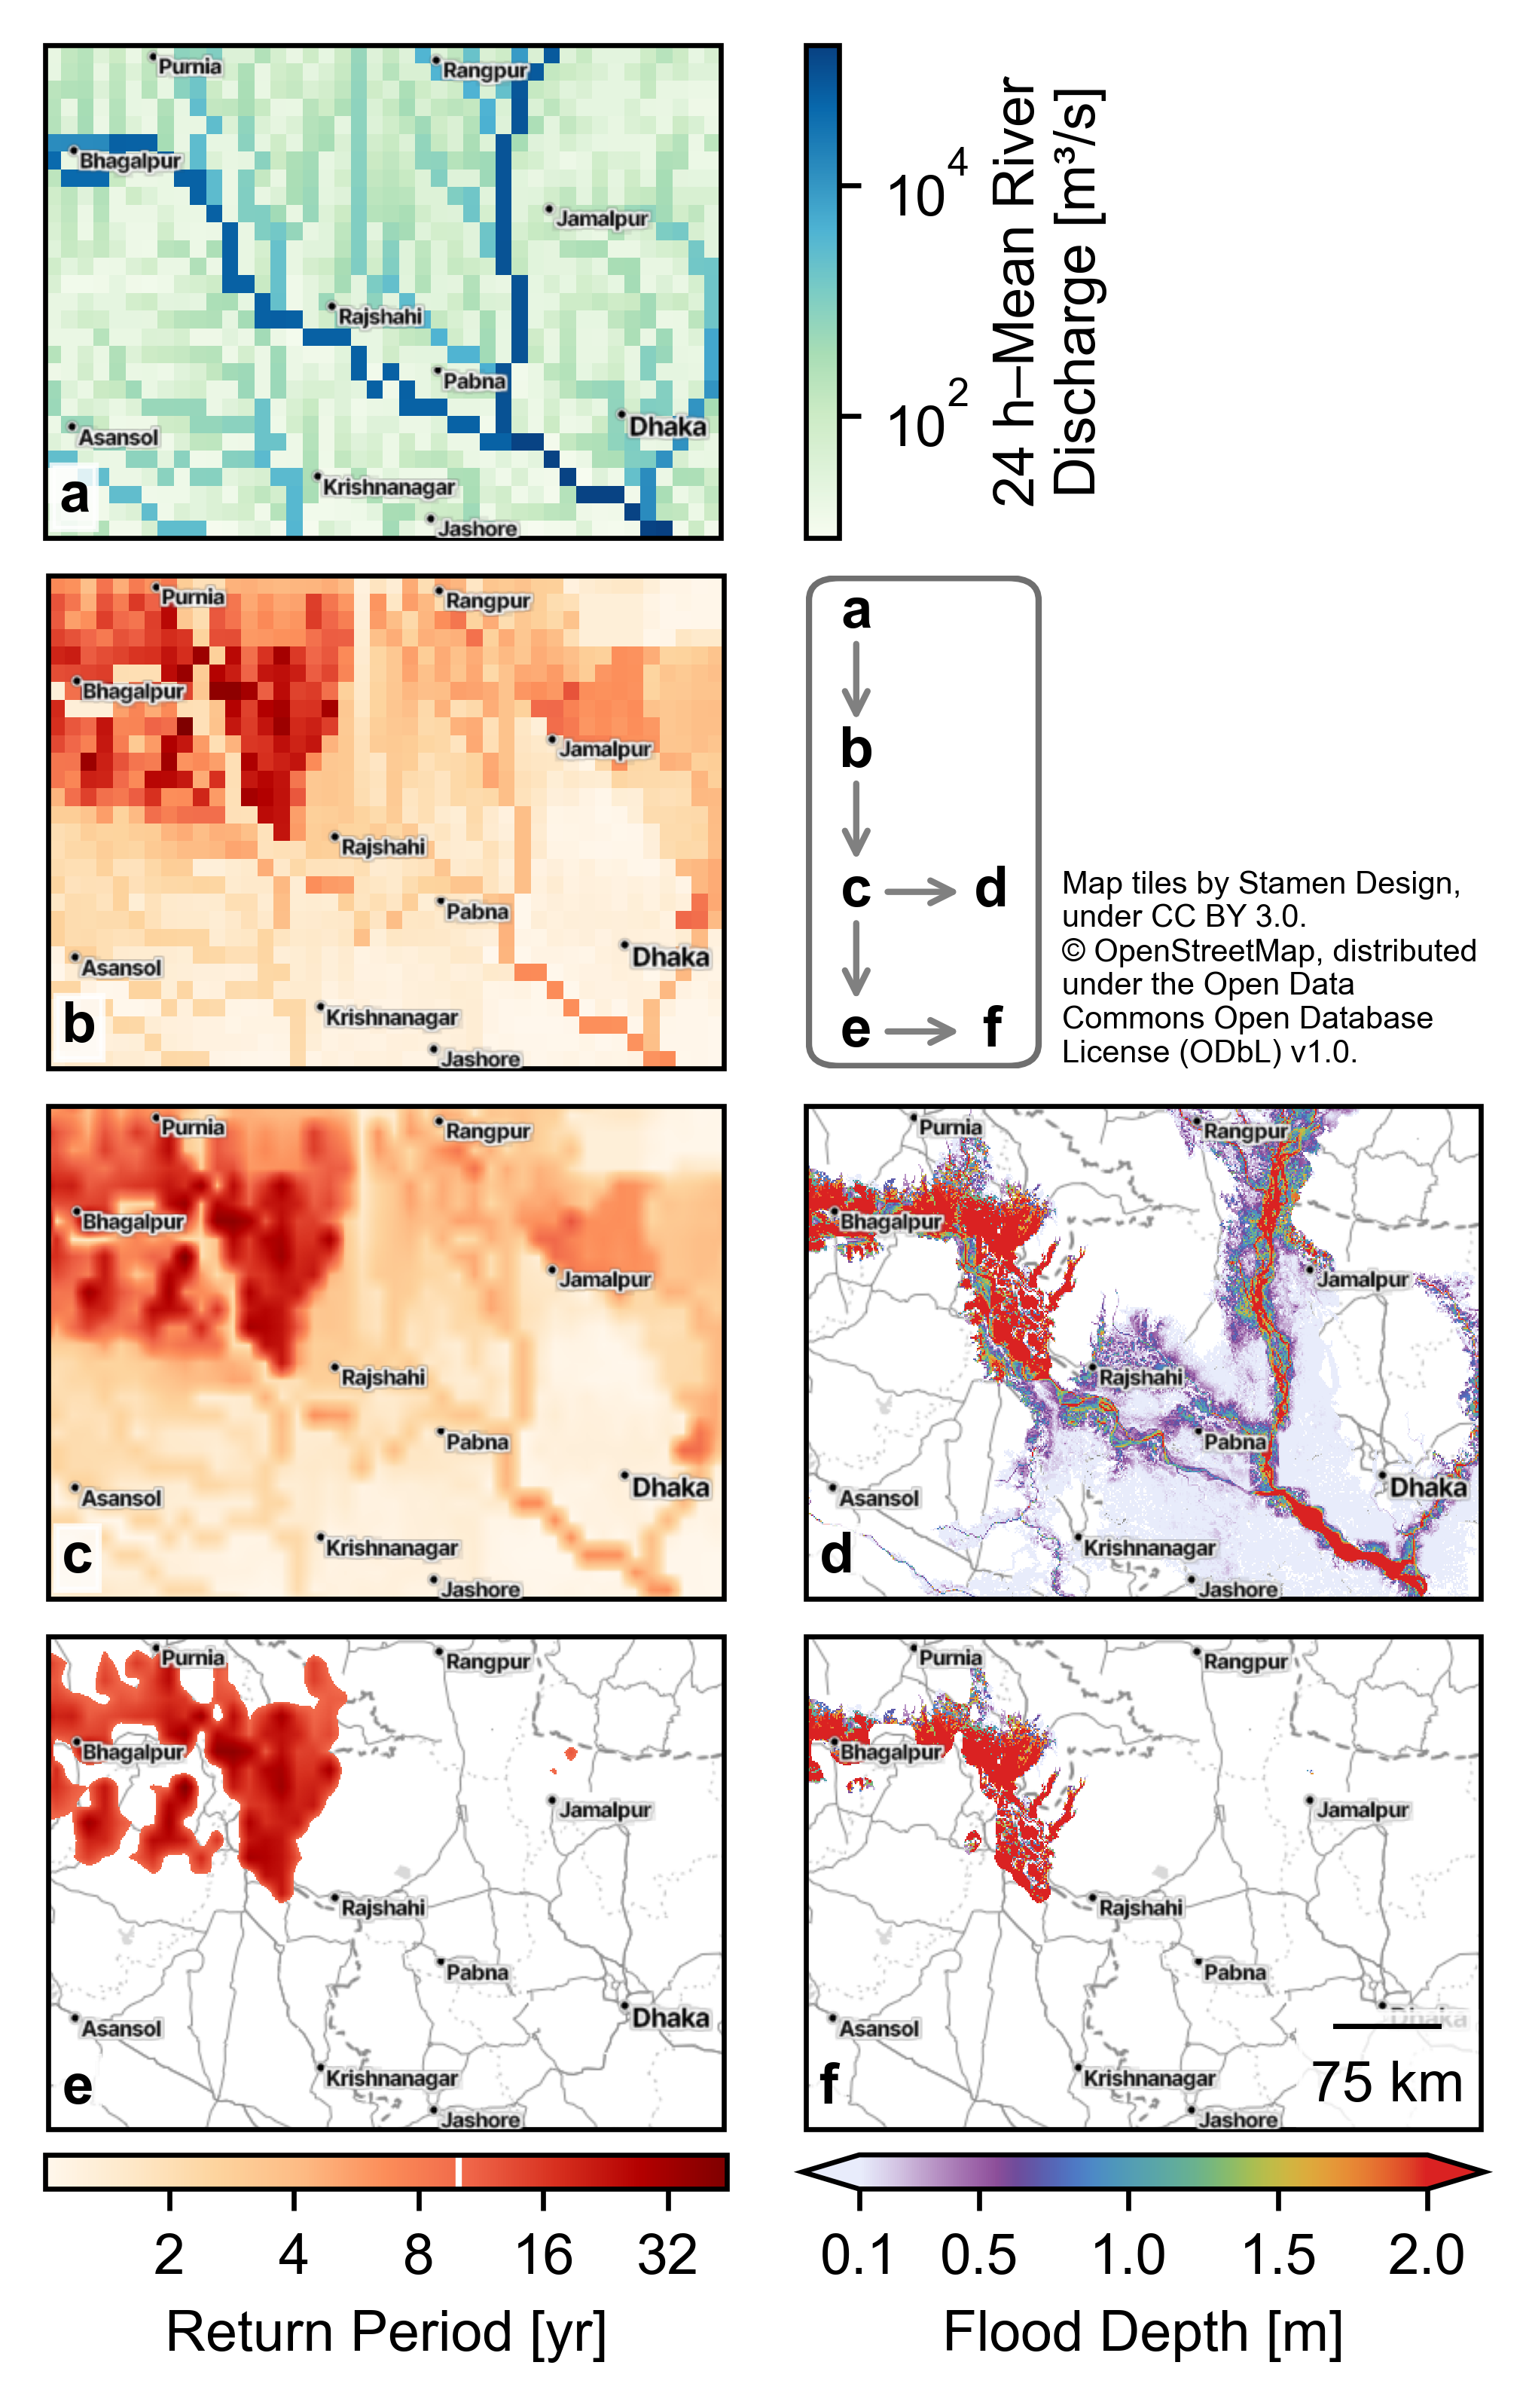

In [46]:
import matplotlib.gridspec as gridspec
from matplotlib.transforms import Bbox
import matplotlib.patches as mpatches

import cartopy.crs as ccrs

# fig = plt.figure(figsize=(FIG_WIDTH_ONE_COL, 1.9*FIG_HEIGHT))
# gs = gridspec.GridSpec(4, 1, figure=fig)
# gss = gs[0].subgridspec(1, 4)
# axes = [[fig.add_subplot(gss[0, :2], projection=ccrs.Mercator()), fig.add_subplot(gss[0, 2])]]
# for idx in range(1, 4):
#     s = gs[idx]
#     sub = s.subgridspec(1, 2)
#     axes.append([fig.add_subplot(sub[0, 0], projection=ccrs.Mercator()), fig.add_subplot(sub[0, 1], projection=ccrs.Mercator())])

# print(axes)
# axes = np.asarray(axes)

fig, axes = plt.subplots(
    4,
    2,
    sharex=True,
    sharey=True,
    figsize=(FIG_WIDTH_ONE_COL, 1.47 * FIG_HEIGHT),
    subplot_kw=dict(projection=ccrs.Mercator()),
)
gs = axes[0, 0].get_gridspec()
for ax in axes[0, :]:
    ax.remove()
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.Mercator())
ax1.set_anchor("SW")
axes[0, 0] = ax1
axes[0, 1] = ax1

# Ganges
latitude = 26, 23.2
longitude = 86.8, 91

data_plot = [
    da.sel(latitude=slice(*latitude), longitude=slice(*longitude)) for da in data
]
plot_kwargs = dict(transform=ccrs.PlateCarree(), add_labels=False, rasterized=True)
# cmap_return_period = plt.get_cmap("Reds")

# NOTE: Too "pale"!
# cmap_BuRd = tol_colors.tol_cmap("BuRd")
# cmap_return_period = LinearSegmentedColormap.from_list("red", cmap_BuRd(np.linspace(0.5, 1.0, 10)))
# cmap_discharge = LinearSegmentedColormap.from_list("blue", cmap_BuRd(np.linspace(0.5, 0.0, 10)))

# cmap_discharge = plt.get_cmap("Blues")
cmap_discharge = plt.get_cmap("GnBu")

# cmap_return_period = plt.get_cmap("Reds")
cmap_return_period = plt.get_cmap("OrRd")

# norm_return_period = mcolors.Normalize(1, data_plot[0].max())
vmin_rp, vmax_rp = data_plot[0].min(), data_plot[0].max()
# cmap_flood = tol_colors.tol_cmap("iridescent")  # Bad!
# cmap_flood = incandescent  # Good
cmap_flood = tol_colors.tol_cmap("rainbow_WhRd").copy()
cmap_flood.set_bad("k", alpha=0.0)
# cmap_flood = plt.get_cmap("viridis_r").copy()
# cmap_flood.set_under("grey")
# cmap_flood = plt.get_cmap("plasma_r").copy()
# cmap_flood.set_under("grey")
vmin_flood, vmax_flood = 0.1, 2

# Discharge
mp1 = da_discharge.sel(latitude=slice(*latitude), longitude=slice(*longitude)).plot(
    ax=axes[0, 0],
    add_colorbar=False,
    cmap=cmap_discharge,
    norm=mcolors.LogNorm(),
    **plot_kwargs,
)

cax = fig.add_axes([0, 0, 1, 1])
fig.colorbar(mp1, cax=cax, label="24 h–Mean River\nDischarge [m³/s]")


def align_cbar(cax, hax, vax):
    hpos = hax.get_position()
    vpos = vax.get_position()
    bb = Bbox.from_extents(vpos.x0, hpos.y0, vpos.x0 + vpos.width * 0.05, hpos.y1)
    if cax.get_position() != bb:
        cax.set_position(bb)
        fig.canvas.draw_idle()


align_cbar(cax, axes[0, 1], axes[1, 1])
fig.canvas.mpl_connect("draw_event", lambda x: align_cbar(cax, axes[0, 1], axes[1, 1]))

# Return period
rp_limit = 1
data_plot[0].plot(
    ax=axes[1, 0],
    add_colorbar=False,
    cmap=cmap_return_period,
    vmin=vmin_rp,
    vmax=vmax_rp,
    norm=mcolors.LogNorm(),
    **plot_kwargs,
)

# Return period interpolated
data_plot[1].plot(
    ax=axes[2, 0],
    add_colorbar=False,
    cmap=cmap_return_period,
    vmin=vmin_rp,
    vmax=vmax_rp,
    norm=mcolors.LogNorm(),
    **plot_kwargs,
)

# Return period interpolated, FLOPROS
rp_protection = 10
flopros_limit = data_plot[1] > rp_protection
mp1 = (
    data_plot[1]
    .where(flopros_limit)
    .plot(
        ax=axes[3, 0],
        add_colorbar=False,
        # cbar_kwargs=dict(
        #     orientation="horizontal",
        #     # ticks=[10, 30, 50],
        #     label="Return Period [yr]",
        #     ticks=mticker.FixedLocator([10, 30, 50])
        # ),
        cmap=cmap_return_period,
        vmin=vmin_rp,
        vmax=vmax_rp,
        norm=mcolors.LogNorm(),
        **plot_kwargs,
    )
)

cb = plt.colorbar(
    mp1, ax=axes[3, 0], label="Return Period [yr]", orientation="horizontal"
)
cb.ax.xaxis.set_minor_locator(mticker.NullLocator())
cb.ax.xaxis.set_major_locator(mticker.FixedLocator([1, 2, 4, 8, 16, 32, 64]))
cb.ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
cb.ax.axvline(x=rp_protection, c="w", lw=1)

# Flood
data_plot[2].where(data_plot[2] > 0).plot(
    ax=axes[2, 1],
    add_colorbar=False,
    cmap=cmap_flood,
    vmin=vmin_flood,
    vmax=vmax_flood,
    **plot_kwargs,
)

# Flood, FLOPROS
flood_flopros = data_plot[2].where(flopros_limit)
flood_flopros.where(flood_flopros > 0).plot(
    ax=axes[3, 1],
    add_colorbar=True,
    cbar_kwargs=dict(
        orientation="horizontal",
        ticks=[vmin_flood, 0.5, 1.0, 1.5, 2],
        # format=mticker.FixedFormatter(["0.1", "1", "2", "3"]),
        label="Flood Depth [m]",
        extendfrac=0.1,
    ),
    cmap=cmap_flood,
    vmin=vmin_flood,
    vmax=vmax_flood,
    **plot_kwargs,
)

axes[0, 0].set_extent([*longitude, *reversed(latitude)], crs=ccrs.PlateCarree())
for ax in axes.flat[2:]:
    ax.set_extent([*longitude, *reversed(latitude)], crs=ccrs.PlateCarree())

# axes[1, 0].set_axis_off()
# axes[1, 1].set_ylabel("Protection for\nReturn Period < 10 yr", labelpad=10)

# for ax in axes.flat[[0, 2, 4, 5, 6, 7]]:
for ax in axes[[0, 1, 2, 2, 3, 3], [0, 0, 0, 1, 0, 1]]:
    # for ax in axes[[2, 3, 3], [1, 0, 1]]:
    add_basemap(ax, zoom=7)  # Before STAMEN Update
    # add_basemap(ax, zoom="auto")
# add_attribution(axes[1, 1], loc="bottom left")
add_scalebar(axes[-1, 1], loc="lower right")

labels = ["a", "b", "c", "d", "e", "f"]
for ax, label in zip(axes[[0, 1, 2, 2, 3, 3], [0, 0, 0, 1, 0, 1]], labels):
    ax.text(
        0.02,
        0.03,
        label,
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="Square, pad=0.1", color="white", alpha=0.8),
        zorder=50,
        transform=ax.transAxes,
        fontweight="bold"
        # fontsize="xx-small",
    )
# text = axes[1, 0].text(
#     0,
#     0,
#     BASEMAPS["stamen"]["attribution"],
#     horizontalalignment="left",
#     verticalalignment="bottom",
#     transform=axes[1, 1].transAxes,
#     fontsize="xx-small",
#     bbox=dict(boxstyle="Square, pad=0.15", color="white", alpha=0.8),
#     zorder=50,
# )
# text.set_in_layout(False)

# axes[0, 0].text(
#     0,
#     0,
#     BASEMAPS["stamen"]["attribution"],
#     horizontalalignment="left",
#     verticalalignment="bottom",
#     transform=axes[0, 0].transAxes,
#     fontsize="xx-small",
#     bbox=dict(boxstyle="Square, pad=0.1", color="white", alpha=0.8),
#     zorder=50,
# )


# Flowchart
font_props = dict(
    fontweight="bold",
    ha="center",
    va="center",
)
arrow_props = dict(
    arrowstyle="->", connectionstyle="arc3", shrinkA=5, shrinkB=5, color="grey"
)
coord_props = dict(
    textcoords="axes fraction",
    xycoords="axes fraction",
)

y_coords = np.linspace(0.5, -0.5, 4, endpoint=True)
x_coords = np.array([0, 1])

y_coords = y_coords * 0.85 + 0.5
x_coords = x_coords * 0.2 + 0.075

axes[1, 1].text(
    x_coords[0], y_coords[0], "a", transform=axes[1, 1].transAxes, **font_props
)
axes[1, 1].text(
    x_coords[0], y_coords[1], "b", transform=axes[1, 1].transAxes, **font_props
)
axes[1, 1].text(
    x_coords[0], y_coords[2], "c", transform=axes[1, 1].transAxes, **font_props
)
axes[1, 1].text(
    x_coords[1], y_coords[2], "d", transform=axes[1, 1].transAxes, **font_props
)
axes[1, 1].text(
    x_coords[0], y_coords[3], "e", transform=axes[1, 1].transAxes, **font_props
)
axes[1, 1].text(
    x_coords[1], y_coords[3], "f", transform=axes[1, 1].transAxes, **font_props
)
axes[1, 1].annotate(
    "",
    xytext=(x_coords[0], y_coords[0]),
    xy=(x_coords[0], y_coords[1]),
    arrowprops=arrow_props,
    **coord_props,
    **font_props,
)
axes[1, 1].annotate(
    "",
    xytext=(x_coords[0], y_coords[1]),
    xy=(x_coords[0], y_coords[2]),
    arrowprops=arrow_props,
    **font_props,
    **coord_props,
)
axes[1, 1].annotate(
    "",
    xytext=(x_coords[0], y_coords[2]),
    xy=(x_coords[0], y_coords[3]),
    arrowprops=arrow_props,
    **coord_props,
    **font_props,
)
axes[1, 1].annotate(
    "",
    xytext=(x_coords[0], y_coords[3]),
    xy=(x_coords[1], y_coords[3]),
    arrowprops=arrow_props,
    **coord_props,
    **font_props,
)
axes[1, 1].annotate(
    "",
    xytext=(x_coords[0], y_coords[2]),
    xy=(x_coords[1], y_coords[2]),
    arrowprops=arrow_props,
    **coord_props,
    **font_props,
)
box = mpatches.FancyBboxPatch(
    [0.05, 0.05],
    0.25,
    0.9,
    boxstyle="round,pad=0.045",
    transform=axes[1, 1].transAxes,
    facecolor="white",
    edgecolor=plt.get_cmap("Greys")(0.8 * 0.8),
    # alpha=0.8,
)
axes[1, 1].add_patch(box)

# Custom attribution
axes[1, 1].text(
    0.38,
    0.0,
    # BASEMAPS["stamen"]["attribution"].replace(", ", ",\n"),
    "Map tiles by Stamen Design,\nunder CC BY 3.0.\n© OpenStreetMap, distributed\nunder the Open Data\nCommons Open Database\nLicense (ODbL) v1.0.",
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=axes[1, 1].transAxes,
    fontsize=5,
    # bbox=dict(boxstyle="Square, pad=0.15", color="white", alpha=0.8),
    zorder=50,
)

# axes[1, 1].set_aspect("equal")

# axes[0, 1].set_axis_off()
axes[1, 1].set_axis_off()
# fig.set_layout_engine(None)


# cb.ax.set_in_layout(False)

fig.savefig("algorithm-2-flat.pdf")